In [6]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
%config InlineBackend.figure_format = 'retina'
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 28
N_CLASSES = 10

In [8]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [9]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((28, 28)),
                                  transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

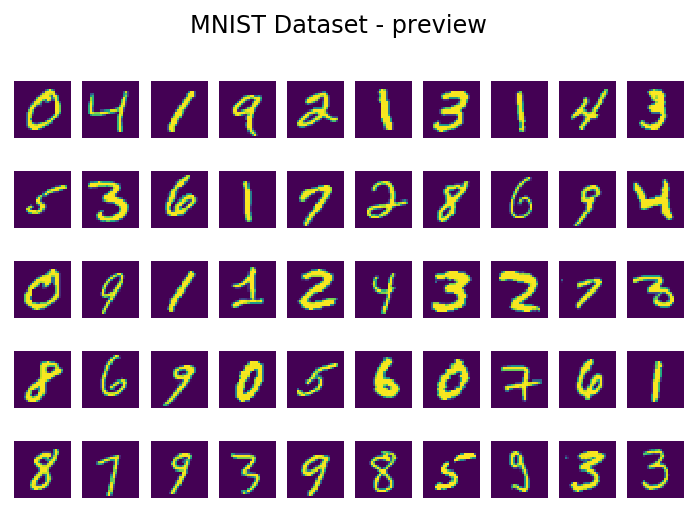

In [10]:
ROW_IMG = 10
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

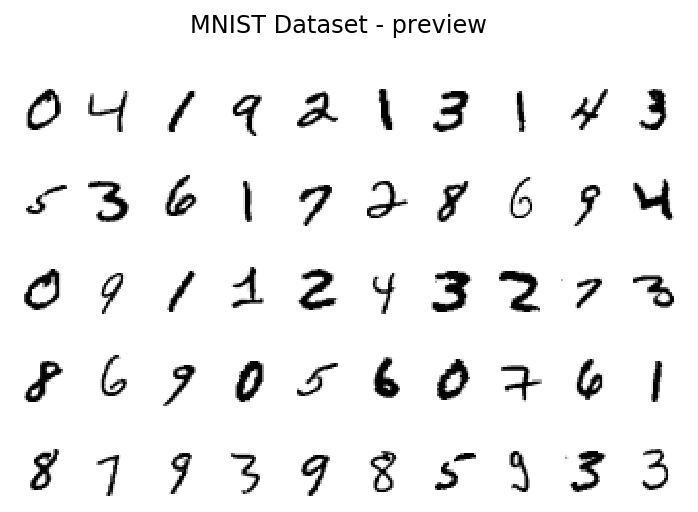

In [11]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [12]:
# construct network
class Basicblock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(Basicblock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=planes, out_channels=planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_planes, out_channels=planes, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.block1 = self._make_layer(block, 16, num_block[0], stride=1)
        self.block2 = self._make_layer(block, 32, num_block[1], stride=2)
        self.block3 = self._make_layer(block, 64, num_block[2], stride=2)
        # self.block4 = self._make_layer(block, 512, num_block[3], stride=2)

        self.outlayer = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_block, stride):
        layers = []
        for i in range(num_block):
            if i == 0:
                layers.append(block(self.in_planes, planes, stride))
            else:
                layers.append(block(planes, planes, 1))
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.conv1(x))
        x = self.block1(x)                       # [200, 64, 28, 28]
        x = self.block2(x)                       # [200, 128, 14, 14]
        x = self.block3(x)                       # [200, 256, 7, 7]
        # out = self.block4(out)
        x = F.avg_pool2d(x, 7)                   # [200, 256, 1, 1]
        x = x.view(x.size(0), -1)                # [200,256]
        out = self.outlayer(x)
        probs = F.softmax(out, dim=1)

        return out,probs

# print(ResNet18)


In [13]:
torch.manual_seed(RANDOM_SEED)

model = ResNet(Basicblock, [1, 1, 1, 1], 10).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

22:40:34 --- Epoch: 0	Train loss: 0.1749	Valid loss: 0.0391	Train accuracy: 98.85	Valid accuracy: 98.73
22:42:55 --- Epoch: 1	Train loss: 0.0487	Valid loss: 0.0584	Train accuracy: 98.26	Valid accuracy: 98.21
22:45:16 --- Epoch: 2	Train loss: 0.0384	Valid loss: 0.0277	Train accuracy: 99.31	Valid accuracy: 99.17
22:47:38 --- Epoch: 3	Train loss: 0.0306	Valid loss: 0.0321	Train accuracy: 99.18	Valid accuracy: 98.96
22:50:01 --- Epoch: 4	Train loss: 0.0256	Valid loss: 0.0201	Train accuracy: 99.53	Valid accuracy: 99.37
22:52:25 --- Epoch: 5	Train loss: 0.0231	Valid loss: 0.0353	Train accuracy: 99.31	Valid accuracy: 98.84
22:54:49 --- Epoch: 6	Train loss: 0.0218	Valid loss: 0.0238	Train accuracy: 99.50	Valid accuracy: 99.17
22:57:19 --- Epoch: 7	Train loss: 0.0180	Valid loss: 0.0296	Train accuracy: 99.35	Valid accuracy: 99.04
22:59:39 --- Epoch: 8	Train loss: 0.0153	Valid loss: 0.0305	Train accuracy: 99.46	Valid accuracy: 98.92
23:02:00 --- Epoch: 9	Train loss: 0.0146	Valid loss: 0.0187	Trai

C:\subwin\software\anaconda\envs\python3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


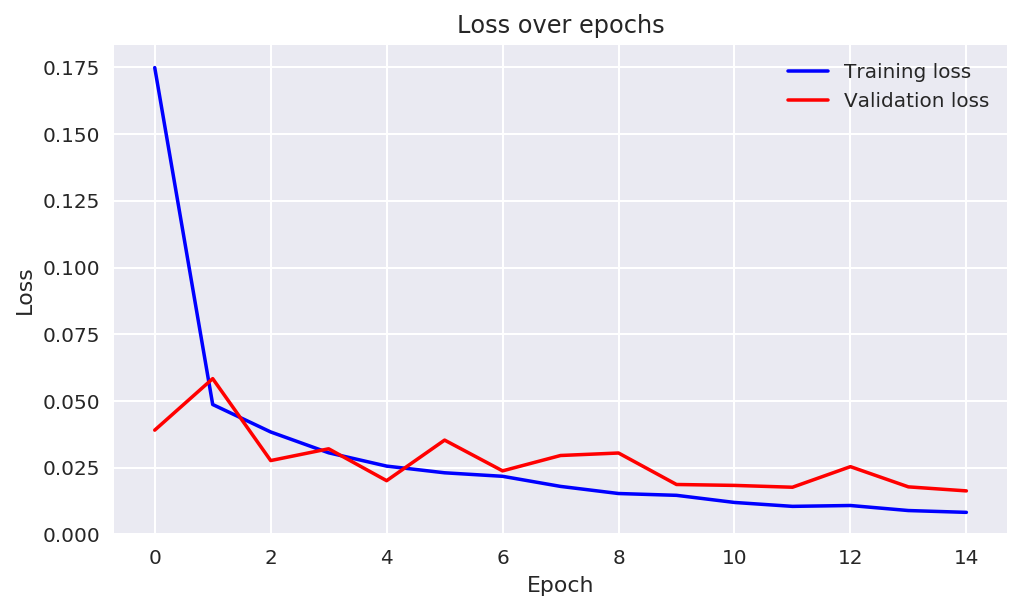

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)


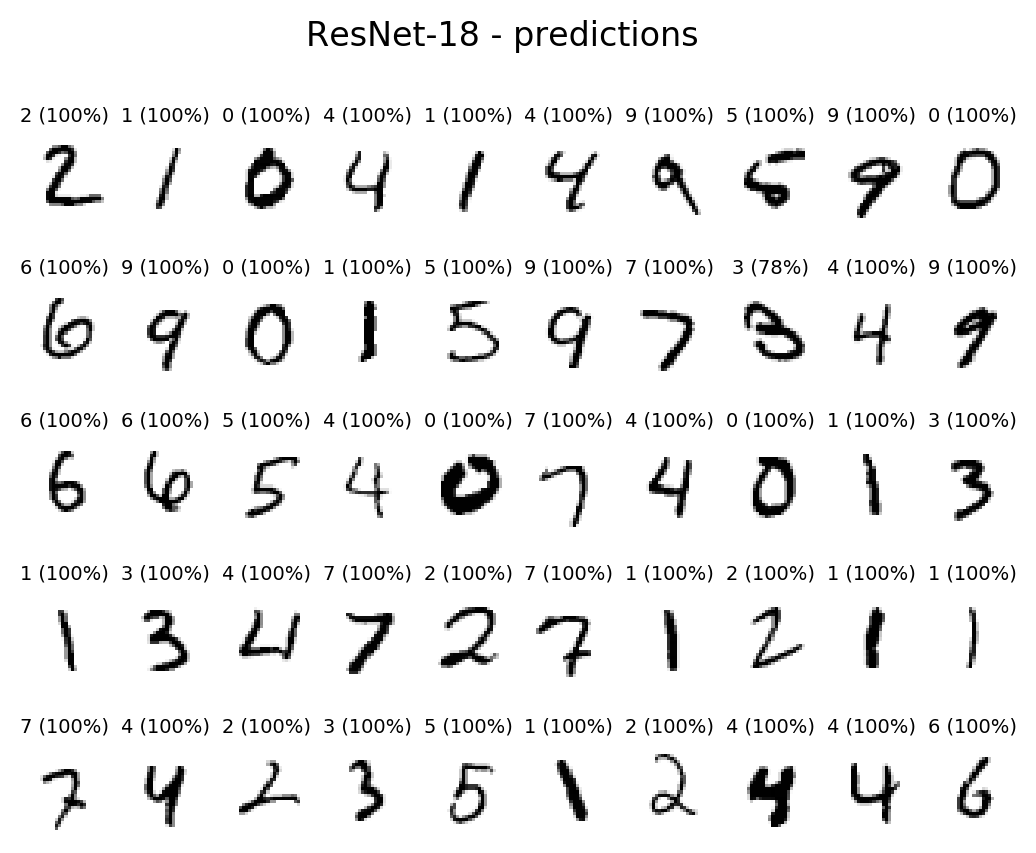

In [15]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('ResNet-18 - predictions');